<a href="https://colab.research.google.com/github/BirchTree1812/emoji_project/blob/Daniil/emoji_sandbox_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Emoji Classification Project - Computer Vision**

### Team Members : `Daniil NOTKIN`, `Yuhan SU` & `Yassine ERRAJI`

## *Importations*

In [16]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from skimage import io, color
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from warnings import filterwarnings
filterwarnings("ignore")

## *Functions*

In [17]:
def load_single_image(path, target_size=(72, 72)):
    """
    Load, preprocess, and resize an image to the target size.

    Args:
        path: Path to the image file
        target_size: Tuple (height, width) to resize the image to. Default is (224, 224) for EfficientNetB0.

    Returns:
        Normalized image array as float32 in range [0, 1]
    """
    img = Image.open(path).convert("RGBA")
    img = np.array(img)

    # RGBA -> RGB
    if img.ndim == 3 and img.shape[2] == 4:
        img = color.rgba2rgb(img)
    # grayscale -> RGB
    elif img.ndim == 2:
        img = np.stack([img] * 3, axis=-1)

    # uint8 conversion
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)

    # Resize to target size for consistent batch dimensions
    # Convert back to PIL, resize, then convert to numpy
    img_pil = Image.fromarray((img * 255).astype(np.uint8) if img.dtype != np.uint8 else img)
    img_pil = img_pil.resize(target_size, Image.Resampling.LANCZOS)
    img = np.array(img_pil)

    # Normalize to [0, 1]
    return img.astype("float32") / 255.0


def imageLoader(files, labels, batch_size):
    """
    This will create a generator for learning by batches.
    """
    L = len(files)

    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            # Batch files (slices)
            batch_files = files[batch_start:limit]

            X_batch = []
            y_batch = []

            for f in batch_files:
                img_id = Path(f).stem       # nom sans extension
                img = load_single_image(f)
                X_batch.append(img)
                y_batch.append(labels[img_id])

            X = np.stack(X_batch)
            Y = np.array(y_batch)

            yield X, Y

            batch_start += batch_size
            batch_end += batch_size

# source code https://stackoverflow.com/questions/47200146/keras-load-images-batch-wise-for-large-dataset


### Dataset

I, myself, have saved the training/testing data on the following path:
/content/drive/MyDrive/Colab Notebooks/emoji_project/data.zip`.

Then, I run the command "unzip '/content/drive/MyDrive/Colab Notebooks/emoji_project/data.zip'". Now, the data is unzipped in the "content" directory, which is where the notebook's code considers to be the initial directory.

In [18]:
PATH = Path("data")
if not PATH.exists():
    raise FileNotFoundError(f"Data folder not found at {PATH.resolve()}")

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
train_dir = PATH / "train"
if not train_dir.exists():
    raise FileNotFoundError(f"Train directory not found at {train_dir.resolve()}")
train_files = sorted([str(p) for p in train_dir.iterdir() if p.is_file()])

In [21]:
test_dir = PATH / "test"
if not test_dir.exists():
    raise FileNotFoundError(f"Test directory not found at {test_dir.resolve()}")
test_files = sorted([str(p) for p in test_dir.iterdir() if p.is_file()])
test_ids = [Path(f).stem for f in test_files]

In [22]:
labels_csv = PATH / "train_labels.csv"
if not labels_csv.exists():
    raise FileNotFoundError(f"Labels file not found at {labels_csv.resolve()}")

y_train_df = pd.read_csv(labels_csv)

# Convert Id column to string format to match image filenames
# This handles cases where IDs might be integers (1) or strings ("00001")
y_train_df["Id"] = y_train_df["Id"].astype(str)

# If IDs are purely numeric strings (e.g., "1", "2"), pad them to match filenames
if all(x.isdigit() for x in y_train_df["Id"]):
    # Determine padding length from the image filenames
    sample_stems = [Path(f).stem for f in train_files]
    max_padding = max(len(s) for s in sample_stems)
    y_train_df["Id"] = y_train_df["Id"].str.zfill(max_padding)

y_train_dct = dict(zip(y_train_df["Id"], y_train_df["Label"]))

# Debug: show sample IDs
print(f"Sample label dict keys: {list(y_train_dct.keys())[:5]}")
print(f"Sample image stems: {[Path(f).stem for f in train_files[:5]]}")


Sample label dict keys: ['00001', '00002', '00003', '00004', '00005']
Sample image stems: ['00001', '00002', '00003', '00004', '00005']


In [23]:
gen = imageLoader(
    files=train_files,
    labels=y_train_dct,
    batch_size=32,
)

## Training

Define a "Liveplot" function, which plots the change in loss/accuracy of a model over epochs. This is very useful, as it allows the user to observe the progress of the model and notice when it begins to over-fit. The early stopping mechanism sometimes is not good enough for that.

In [24]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf

class LivePlot(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epochs = []
        self.losses = []
        self.accs = []
        self.val_losses = []
        self.val_accs = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs.append(epoch + 1)
        self.losses.append(logs.get("loss"))
        self.accs.append(logs.get("accuracy"))
        self.val_losses.append(logs.get("val_loss"))
        self.val_accs.append(logs.get("val_accuracy"))

        clear_output(wait=True)
        plt.figure(figsize=(10,4))

        # Loss plot
        plt.subplot(1,2,1)
        plt.plot(self.epochs, self.losses, label="train loss")
        if any(v is not None for v in self.val_losses):
            plt.plot(self.epochs, self.val_losses, label="val loss")
        plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.grid(True)

        # Accuracy plot
        plt.subplot(1,2,2)
        plt.plot(self.epochs, self.accs, label="train acc")
        if any(v is not None for v in self.val_accs):
            plt.plot(self.epochs, self.val_accs, label="val acc")
        plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.grid(True)

        plt.show()


### Model Architecture & Strategy

We use **Transfer Learning with EfficientNetB0** for several reasons:

1. **Pre-trained Weights**: EfficientNetB0 is trained on ImageNet with 1.3M images across 1000 classes. These learned features (edge detection, texture recognition, etc.) transfer well to emoji classification.

2. **Efficiency-Accuracy Trade-off**: EfficientNetB0 offers excellent accuracy (77% top-1 on ImageNet) while remaining lightweight (5.3M parameters), enabling faster training and inference.

3. **Emoji Domain**: Emojis are stylized, small images where extracting visual features (shapes, colors, patterns) is crucial - areas where CNNs excel. Transfer learning accelerates learning by leveraging pre-trained feature extractors.

4. **Data Augmentation**: We apply random rotations, shifts, and zoom to increase training diversity and improve generalization on unseen emoji variations.

5. **Regularization**: Dropout prevents overfitting; we freeze early layers and only fine-tune later layers to preserve learned features while adapting to emoji-specific patterns.


Other changes:
+ Learning rate is 3e-4, since that strikes a good balance between overfitting and underfitting

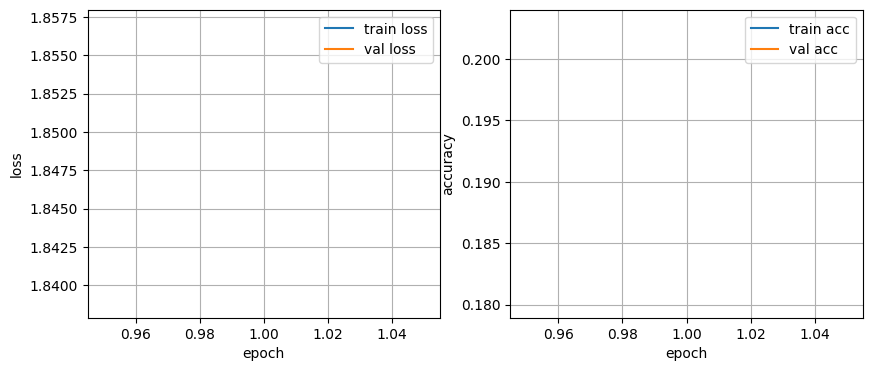

555/555 ━━━━━━━━━━━━━━━━━━━━ 79s 94ms/step - accuracy: 0.1765 - loss: 1.8737 - val_accuracy: 0.2029 - val_loss: 1.8388
Epoch 2/10
223/555 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step - accuracy: 0.1958 - loss: 1.8540

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# We start by listing the existing labels
unique_labels = y_train_df["Label"].unique().tolist()

# Create a mapping from emoji label (string) to class index (integer)
# This is required because the model uses sparse_categorical_crossentropy which expects integer labels
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# Convert the label dictionary from string labels to integer indices
y_train_dct_indexed = {img_id: label_to_index[label] for img_id, label in y_train_dct.items()}

print(f"Label mapping created: {len(label_to_index)} classes")
print(f"Sample mapping: {list(label_to_index.items())[:5]}")

# ============================================================================
# STEP 1: Define Advanced Data Augmentation
# ============================================================================
# Data augmentation artificially increases training data diversity by applying
# random transformations. This helps the model generalize better to variations
# in emoji styles and orientations.
augmentation = ImageDataGenerator(
    rotation_range=45,           # Random rotations up to 45 degrees
    width_shift_range=0.3,       # Horizontal shift by 30%
    height_shift_range=0.3,      # Vertical shift by 30%
    zoom_range=0.3,             # Random zoom between 0.7x and 1.3x
    horizontal_flip=True,        # Mirror images (valid for many emojis)
    fill_mode='nearest'          # Fill pixels using nearest neighbor
)

# ============================================================================
# STEP 2: Create Modified Image Loader with Data Augmentation
# ============================================================================
def imageLoader_augmented(files, labels, batch_size, augment=True):
    """
    Enhanced image loader with optional data augmentation.
    Augmentation is applied during training but disabled for test/validation.

    Args:
        files: List of image file paths
        labels: Dictionary mapping image IDs to integer class indices
        batch_size: Batch size for training
        augment: Whether to apply data augmentation
    """
    L = len(files)
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < L:
            limit = min(batch_end, L)
            batch_files = files[batch_start:limit]

            X_batch = []
            y_batch = []
            for f in batch_files:
                img_id = Path(f).stem

                # Robustly handle ID lookups: try original, then convert to int if numeric
                if img_id not in labels:
                    try:
                        # Try converting to integer then back with padding
                        img_id_int = int(img_id)
                        # Find the correct padded version
                        padded_versions = [k for k in labels.keys() if int(k) == img_id_int]
                        if padded_versions:
                            img_id = padded_versions[0]
                        else:
                            print(f"Warning: Could not find label for {img_id}")
                            continue
                    except ValueError:
                        print(f"Warning: Could not find label for {img_id}")
                        continue

                img = load_single_image(f)
                X_batch.append(img)
                y_batch.append(labels[img_id])  # Now this is an integer index

            if len(X_batch) > 0:  # Only yield non-empty batches
                X = np.stack(X_batch)
                Y = np.array(y_batch, dtype=np.int32)  # Ensure integer dtype

                # Apply augmentation only if requested (training phase)
                if augment:
                    X = next(augmentation.flow(X, Y, batch_size=len(X), shuffle=False))[0]

                yield X, Y

            batch_start += batch_size
            batch_end += batch_size

# ============================================================================
# STEP 3: Build Transfer Learning Model
# ============================================================================
# Load EfficientNetB0 with ImageNet weights
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,           # Remove classification head, we'll add custom layers
    input_shape=(72, 72, 3)    # Standard size for pre-trained model
)

# Freeze early layers: these extract generic features (edges, textures)
# that are useful across domains. We only fine-tune later layers.
base_model.trainable = False

# Build custom classification head
# model = models.Sequential([
#     base_model,
#     layers.GlobalAveragePooling2D(),
#     layers.BatchNormalization(),
#     layers.Dense(256, use_bias=False),
#     layers.BatchNormalization(),
#     layers.Activation("relu"),
#     layers.Dropout(0.3),
#     layers.Dense(len(unique_labels), activation="softmax")
# ])

from tensorflow.keras import layers, models

model = models.Sequential([
    base_model,
    layers.Conv2D(128, 1, activation="relu"),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(unique_labels), activation="softmax")
])


# Compile with Adam optimizer (adaptive learning rates) and categorical crossentropy
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',  # For integer labels (0, 1, 2, ...)
    metrics=['accuracy']
)

print(f"Model created with {model.count_params():,} total parameters")
print(f"Number of emoji classes: {len(unique_labels)}")
print(f"Training samples: {len(train_files)}")

# ============================================================================
# STEP 4: Train the Model
# ============================================================================
liveplot = LivePlot()

# Early stopping: if validation accuracy plateaus, stop training to save time
early_stopping = EarlyStopping(
    monitor='loss',  # Monitor training loss
    patience=3,      # Stop if no improvement for 3 epochs
    restore_best_weights=True
)

split = int(0.9 * len(train_files))
train_files_split = train_files[:split]
val_files_split = train_files[split:]

train_gen = imageLoader_augmented(train_files_split, y_train_dct_indexed, batch_size=16, augment=True)
val_gen   = imageLoader_augmented(val_files_split,   y_train_dct_indexed, batch_size=16, augment=False)

history = model.fit(
    train_gen,
    steps_per_epoch=len(train_files_split)//16,
    validation_data=val_gen,
    validation_steps=len(val_files_split)//16,
    epochs=10,
    callbacks=[liveplot],
    verbose=1
)

print("Training completed!")

# ============================================================================
# STEP 5: Generate Predictions on Test Set
# ============================================================================
def predict_with_my_amazing_model(test_files):
    """
    Generate emoji predictions using the trained EfficientNetB0 model.

    Process:
    1. Load and preprocess each test image
    2. Feed through the trained model
    3. Extract the class with highest probability
    4. Map class index back to emoji label string

    Returns:
        predictions: numpy array of predicted emoji labels (strings)
    """
    predictions = []

    # Process in batches for efficiency
    for i in range(0, len(test_files), 16):
        batch_files = test_files[i:min(i+16, len(test_files))]
        X_batch = []

        for f in batch_files:
            img = load_single_image(f)
            X_batch.append(img)

        X = np.stack(X_batch)

        # Get probability distribution over classes
        probs = model.predict(X, verbose=0)

        # Get predicted class index (highest probability)
        predicted_indices = np.argmax(probs, axis=1)

        # Map class indices back to emoji label strings
        batch_predictions = [index_to_label[idx] for idx in predicted_indices]
        predictions.extend(batch_predictions)

    return np.array(predictions)

print("Generating test predictions...")
y_test_pred = predict_with_my_amazing_model(test_files)
print(f"Predictions generated for {len(y_test_pred)} test samples")
print(f"Unique predictions: {np.unique(y_test_pred)}")
y_test_pred


In [ ]:
test_ids_sr = pd.Series(test_ids, name="Id")
y_test_pred_sr = pd.Series(y_test_pred, name="Label")
submission_df = pd.concat([test_ids_sr, y_test_pred_sr], axis=1)
submission_df.head()

In [ ]:
submission_df.to_csv("submission.csv", index=False)